<a href="https://colab.research.google.com/github/vothane/whistling-birds/blob/master/whistling_birds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install SwarmPackagePy



1.   **Initialization Phase**: Generate a random solution for each bee of colony.
2.   **Tasking Bees**: Each bee improve global solution by searching for local neighboring solutions.
3. **Untasked Bees**: Learn from bees from above and improve heuristics
4. **Scout Bees**: Search for better optimizations





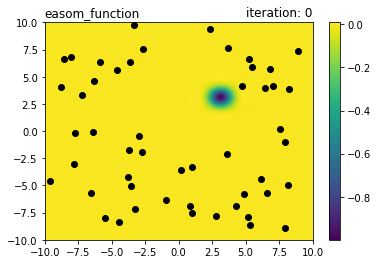

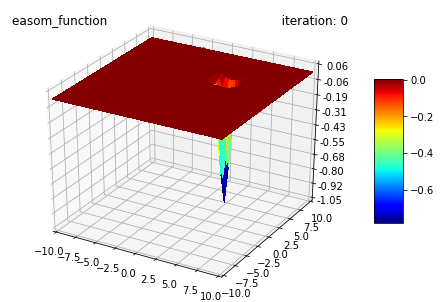

In [5]:
import SwarmPackagePy
from SwarmPackagePy import testFunctions as tf
from SwarmPackagePy import animation, animation3D

art_bee_col = SwarmPackagePy.aba(50, tf.easom_function, -10, 10, 2, 50)
animation(art_bee_col.get_agents(), tf.easom_function, -10, 10)
animation3D(art_bee_col.get_agents(), tf.easom_function, -10, 10)
